In [1]:
import scanpy as sc
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 1. Load and preprocess PBMC3k
adata = sc.datasets.pbmc3k()
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=50, subset=True, flavor="seurat")
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
genes = list(adata.var_names)

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

In [2]:
# 2. GRN inference
def infer_GRN(X, n_trees=50):
    n_cells, n_genes = X.shape
    A = np.zeros((n_genes, n_genes))
    for j in range(n_genes):
        y = X[:, j]
        rf = RandomForestRegressor(n_estimators=n_trees, n_jobs=-1, random_state=0)
        rf.fit(X, y)
        A[:, j] = rf.feature_importances_
    return A


# 3. Normalize adjacency
def normalize_adjacency(A):
    row_sums = A.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    return A / row_sums


# 4. Random-walk-with-restart perturbation
def simulate_tf_perturbation(A, tf_idx, delta=1.0, alpha=0.85, tol=1e-6, max_iter=100):
    n = A.shape[0]
    p0 = np.zeros(n)
    p0[tf_idx] = delta
    T = normalize_adjacency(A)
    p = p0.copy()
    for _ in range(max_iter):
        p_next = alpha * T.dot(p) + (1 - alpha) * p0
        if np.linalg.norm(p_next - p, ord=1) < tol:
            break
        p = p_next
    return p

(50,)
(50,)
(50,)


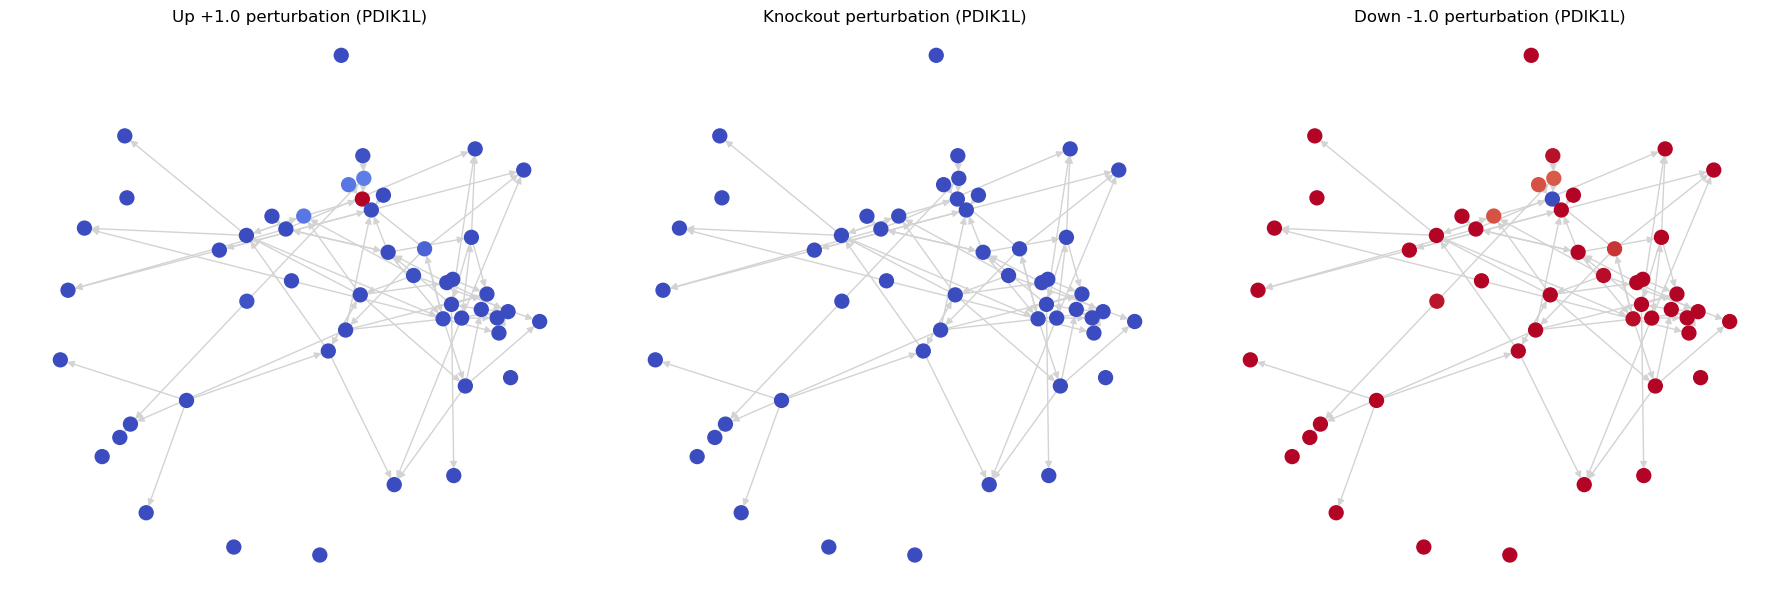

In [6]:
# 5. Infer GRN on PBMC
A = infer_GRN(X, n_trees=100)

# 6. Choose a TF to perturb from the PBMC HVGs, ex SPI1
tf_name = "SPI1" if "SPI1" in genes else genes[0]
tf_idx = genes.index(tf_name)

# 7. Run perturbations: up, knockout, down
modes = [(1.0, "Up +1.0"), (0.0, "Knockout"), (-1.0, "Down -1.0")]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=100)

for ax, (delta, title) in zip(axes, modes):
    p = simulate_tf_perturbation(A, tf_idx, delta=delta)
    G = nx.DiGraph()
    for i, g in enumerate(genes):
        G.add_node(g, p=p[i])
    thresh = np.percentile(A, 95)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if i == j:
                continue
            if A[i, j] >= thresh:
                G.add_edge(genes[i], genes[j])
    pos = nx.spring_layout(G, seed=42)
    vals = [G.nodes[n]["p"] for n in G.nodes()]
    nx.draw(
        G,
        pos,
        ax=ax,
        node_color=vals,
        cmap="coolwarm",
        with_labels=False,
        node_size=100,
        edge_color="lightgray",
    )
    ax.set_title(f"{title} perturbation ({tf_name})")

plt.tight_layout()
plt.show()